In [47]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

In [48]:
## ---- Notebook Variables ---- ##
nb_variables = {'window': 4, 'train_amount': 0.9}

In [49]:
df = pd.read_csv('../Iquitos_train.csv', index_col = 0)
df.index = pd.to_datetime(df.index)
df.sort_index(inplace = True)

In [50]:
print('------ Basic Stats about the San Juan Training set ------ \n')
print(f'- Number of rows of the training set: {len(df)} \n')
print(f'- Number of columns of the training set: {len(df.columns)}, where the last on is the label \n')
perc = np.round(100 * df.isna().sum().sum() / (len(df) * len(df.columns)), 2)
print(f'- Percentage of missing values across the entire dataset {perc}% \n')
url = 'https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/page/82/'
print(f'- Description for all variables can be found here: {url} \n')

------ Basic Stats about the San Juan Training set ------ 

- Number of rows of the training set: 520 

- Number of columns of the training set: 23, where the last on is the label 

- Percentage of missing values across the entire dataset 1.4% 

- Description for all variables can be found here: https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/page/82/ 



In [51]:
# When we are filling NAs using a rolling window = 4, it means that if a value is NA then we take the mean
# of the 3 values that come before it chronologically and assign it to that value.
# Also the values that are not NA do not change (Just to be clear)!

In [52]:
for col in df.columns[:-1]: # exclude the label variable
    df[col] = df[col].fillna(df.rolling(window = nb_variables['window'],
                                        min_periods = 1).mean()[col])

In [53]:
new_perc = np.round(100 * df.isna().sum().sum() / (len(df) * len(df.columns)), 2)
print(f'- The amount of NAs was reduced to {new_perc}% \n')
print('- For the next step we will fill the remaining NAs with zeroes \n')

- The amount of NAs was reduced to 0.11% 

- For the next step we will fill the remaining NAs with zeroes 



In [54]:
df = df.fillna(0)

In [55]:
new_perc = np.round(100 * df.isna().sum().sum() / (len(df) * len(df.columns)), 2)
print(f'- The amount of NAs was reduced to {new_perc}% \n')
print(f'- We are ready to make predictions! \n')

- The amount of NAs was reduced to 0.0% 

- We are ready to make predictions! 



In [56]:
## ----- Further Data Engineering ----- ##

In [57]:
df.drop(['ndvi_ne', 'ndvi_nw'], axis = 1, inplace = True)
df.drop('reanalysis_sat_precip_amt_mm', axis = 1, inplace = True)
df[['reanalysis_air_temp_k', 'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
    'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k']] += -273.15

In [58]:
min_temp = pd.Series(np.mean(df[[col for col in df.columns if '_min_' in col]].values, axis = 1))
min_temp.index = df.index
df['min_temp'] = min_temp
df.drop([col for col in df.columns if '_min_' in col], axis = 1, inplace = True)

In [59]:
max_temp = pd.Series(np.mean(df[[col for col in df.columns if '_max_' in col]].values, axis = 1))
max_temp.index = df.index
df['max_temp'] = max_temp
df.drop([col for col in df.columns if '_max_' in col], axis = 1, inplace = True)

In [60]:
reanalysis_avg_temp_c = pd.Series(np.mean(df[['reanalysis_avg_temp_k', 'reanalysis_air_temp_k']], axis = 1))
reanalysis_avg_temp_c.index = df.index
df['reanalysis_avg_temp_c'] = reanalysis_avg_temp_c
df.drop(['reanalysis_avg_temp_k', 'reanalysis_air_temp_k'], axis = 1, inplace = True)

In [61]:
cols = df.columns.tolist()
cols = cols[-3:] + cols[:-3]

<AxesSubplot: >

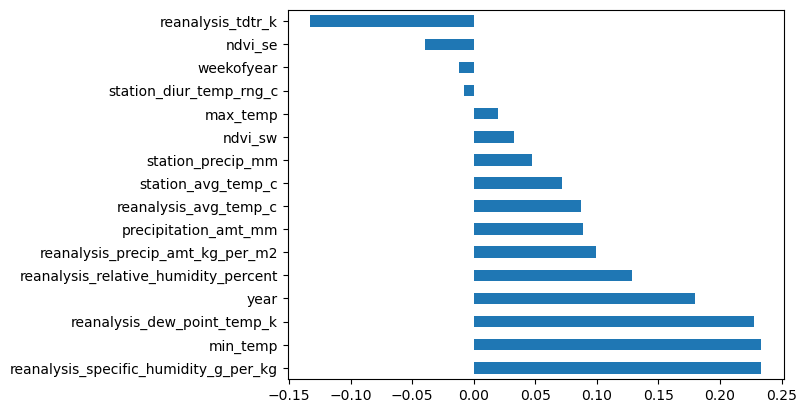

In [62]:
correlations = df.corr()
(correlations
     .total_cases
     .drop('total_cases')
     .sort_values(ascending=False)
     .plot
     .barh())

In [63]:
df.values.shape

(520, 17)

In [64]:
df.to_csv('df_for_testing.csv')

In [65]:
window = nb_variables['window']
xin = []
yout = []
for i in range(window, len(df)):
    xin.append(df.values[i - window : i, : -1])
    yout.append(df.values[i, -1])
    
xin = np.array(xin)
yout = np.array(yout).reshape(len(yout), 1)

In [66]:
xin.shape

(516, 4, 16)

In [67]:
yout.shape

(516, 1)

In [68]:
train_amount = nb_variables['train_amount']
x_train = xin[:int(train_amount * len(df))]  # df.iloc[:int(train_amount * len(df)), : -1]
x_test = xin[int(train_amount * len(df)):]   # df.iloc[int(train_amount * len(df)):, : -1]

y_train = yout[:int(train_amount * len(df))]  # df.iloc[:int(train_amount * len(df)), -1]
y_test = yout[int(train_amount * len(df)):]   # df.iloc[int(train_amount * len(df)):, -1]

In [69]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.data import Dataset
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

In [70]:
opt = Adam(learning_rate = 5e-5)

model = Sequential()
model.add(LSTM(50, activation = 'tanh', input_shape = (xin.shape[1], xin.shape[2]), return_sequences = True))
model.add(BatchNormalization())
model.add(LSTM(50, activation = 'tanh', input_shape = (xin.shape[1], 50)))
model.add(BatchNormalization())
model.add(Dense(100, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(75, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(25, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer = opt, loss='mae')

In [71]:
def lr_scheduler(epoch, lr):
    if epoch <= 80:
        return lr
    else:
        return lr * 0.99

In [72]:
# -- Checkpoints -- #
lr_scheduler = LearningRateScheduler(lr_scheduler)
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 75, restore_best_weights=True, mode = 'min')
checkpoint = ModelCheckpoint(monitor = 'val_loss', filepath = '../models/iq_lstm.keras', save_best_only = True, 
                             mode = 'min', save_freq = 'epoch')

In [73]:
history = model.fit(x_train, y_train, batch_size = 4, validation_data = (x_test, y_test), epochs=220, verbose=2,
                   use_multiprocessing = True, callbacks = [checkpoint, lr_scheduler])

Epoch 1/220
117/117 - 2s - loss: 25.2197 - val_loss: 25.9856 - lr: 5.0000e-05 - 2s/epoch - 16ms/step
Epoch 2/220
117/117 - 0s - loss: 25.2238 - val_loss: 25.8650 - lr: 5.0000e-05 - 234ms/epoch - 2ms/step
Epoch 3/220
117/117 - 0s - loss: 25.1743 - val_loss: 25.9488 - lr: 5.0000e-05 - 212ms/epoch - 2ms/step
Epoch 4/220
117/117 - 0s - loss: 25.1846 - val_loss: 26.1904 - lr: 5.0000e-05 - 208ms/epoch - 2ms/step
Epoch 5/220
117/117 - 0s - loss: 25.1493 - val_loss: 26.0709 - lr: 5.0000e-05 - 208ms/epoch - 2ms/step
Epoch 6/220
117/117 - 0s - loss: 25.0469 - val_loss: 25.7067 - lr: 5.0000e-05 - 232ms/epoch - 2ms/step
Epoch 7/220
117/117 - 0s - loss: 25.0777 - val_loss: 25.9538 - lr: 5.0000e-05 - 210ms/epoch - 2ms/step
Epoch 8/220
117/117 - 0s - loss: 24.9358 - val_loss: 25.9527 - lr: 5.0000e-05 - 207ms/epoch - 2ms/step
Epoch 9/220
117/117 - 0s - loss: 24.9104 - val_loss: 25.7043 - lr: 5.0000e-05 - 230ms/epoch - 2ms/step
Epoch 10/220
117/117 - 0s - loss: 24.9119 - val_loss: 25.6853 - lr: 5.0000e

Epoch 80/220
117/117 - 0s - loss: 17.9475 - val_loss: 15.9063 - lr: 5.0000e-05 - 210ms/epoch - 2ms/step
Epoch 81/220
117/117 - 0s - loss: 17.7290 - val_loss: 15.5535 - lr: 5.0000e-05 - 233ms/epoch - 2ms/step
Epoch 82/220
117/117 - 0s - loss: 17.5723 - val_loss: 15.6586 - lr: 4.9500e-05 - 220ms/epoch - 2ms/step
Epoch 83/220
117/117 - 0s - loss: 17.5460 - val_loss: 15.2734 - lr: 4.9005e-05 - 247ms/epoch - 2ms/step
Epoch 84/220
117/117 - 0s - loss: 17.2639 - val_loss: 14.9919 - lr: 4.8515e-05 - 254ms/epoch - 2ms/step
Epoch 85/220
117/117 - 0s - loss: 17.2443 - val_loss: 15.9193 - lr: 4.8030e-05 - 223ms/epoch - 2ms/step
Epoch 86/220
117/117 - 0s - loss: 17.1334 - val_loss: 15.5744 - lr: 4.7549e-05 - 214ms/epoch - 2ms/step
Epoch 87/220
117/117 - 0s - loss: 16.8490 - val_loss: 15.9673 - lr: 4.7074e-05 - 206ms/epoch - 2ms/step
Epoch 88/220
117/117 - 0s - loss: 16.6646 - val_loss: 15.8698 - lr: 4.6603e-05 - 213ms/epoch - 2ms/step
Epoch 89/220
117/117 - 0s - loss: 16.3014 - val_loss: 14.5881 - 

Epoch 159/220
117/117 - 0s - loss: 7.0568 - val_loss: 6.4873 - lr: 2.2830e-05 - 220ms/epoch - 2ms/step
Epoch 160/220
117/117 - 0s - loss: 7.2527 - val_loss: 6.2577 - lr: 2.2602e-05 - 233ms/epoch - 2ms/step
Epoch 161/220
117/117 - 0s - loss: 7.0704 - val_loss: 5.9438 - lr: 2.2376e-05 - 239ms/epoch - 2ms/step
Epoch 162/220
117/117 - 0s - loss: 6.8852 - val_loss: 5.8358 - lr: 2.2152e-05 - 232ms/epoch - 2ms/step
Epoch 163/220
117/117 - 0s - loss: 6.7373 - val_loss: 5.7328 - lr: 2.1931e-05 - 229ms/epoch - 2ms/step
Epoch 164/220
117/117 - 0s - loss: 6.8391 - val_loss: 6.1289 - lr: 2.1712e-05 - 208ms/epoch - 2ms/step
Epoch 165/220
117/117 - 0s - loss: 6.7675 - val_loss: 5.7136 - lr: 2.1494e-05 - 229ms/epoch - 2ms/step
Epoch 166/220
117/117 - 0s - loss: 6.4770 - val_loss: 5.8041 - lr: 2.1279e-05 - 207ms/epoch - 2ms/step
Epoch 167/220
117/117 - 0s - loss: 6.4493 - val_loss: 6.0073 - lr: 2.1067e-05 - 207ms/epoch - 2ms/step
Epoch 168/220
117/117 - 0s - loss: 6.4381 - val_loss: 5.8434 - lr: 2.0856

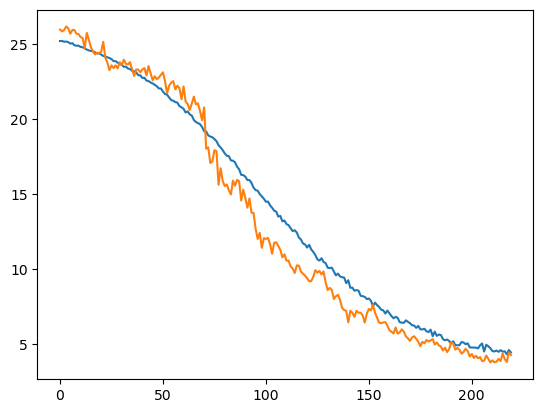

In [74]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [75]:
predictions = model.predict(xin)
predictions = np.round(predictions).astype('int32')
predictions[predictions < 0] = 0
predictions.shape

17/17 [==============================] - 0s 1ms/step


(516, 1)

In [76]:
dataset_mae = np.mean(np.abs(predictions - yout))
print(f'Train Dataset MAE: {dataset_mae}')

Train Dataset MAE: 3.7613939645607326
